# Predicting Heart Disease

In this notebook we will explore a dataset detailing health information from patients at a hospital.  Our goal will be to predict whether or not they are at risk of heart disease.

### Table of Contents

1. [**Column Descriptions**](#columns)
2. [**Importing Libraries**](#libraries)
3. [**Preprocessing**](#preprocessing)
  1. Standardize column names and value names to snake_case
  2. Check for nans
  3. Check for duplicates
  4. Categorical columns: check distribution, get dummies
  5. Numerical columns: check for any weird/obviously wrong values/outliers
4. [**Feature Selection**](#featsel)
  1. Check for highly correlated features
  2. Use a tuned Random Forest Classifier to select features
5. [**Training and Testing**](#traintest)
6. [**Comparing Results, Stacked Ensemble**](#stacked)

<a class="anchor" id="columns"></a>

# Column Descriptions

This dataset consists of 11 predictive columns and 1 target column.  They are as follows:

**Age** - Patient's age (numeric, integer)

**Sex** - Patient's gender (categorical, M or F)

**ChestPainType** - Type of chest pain experienced by the patient (categorical, [1, 2, 3, 4])  
*Values: 1 - typical angina, 2 - atypical angina, 3 - non-anginal pain, 4 - asymptomatic (Nominal)*

**RestingBP** - Patient's resting blood pressure in mmHg (numeric, integer)

**Cholesterol** - Patient's cholesterol level in mg/dl (numeric, integer)

**FastingBS** - Does the patient have blood sugar > 120mg/dl after fasting (categorical, 0 or 1)

**RestingECG** - Results of an electrocardiogram while at rest  
*Values: 0 - Normal, 1 - Abnormality in ST-T wave,  2 - Left ventricular hypertrophy (Nominal)*

**MaxHR** - Maximum heart rate observed in patient (numeric, integer)

**ExerciseAngina** - Was angina exercise-induced? (categorical, 0 or 1)

**Oldpeak** - Exercise induced ST-depression as compared with being at a state of rest (numeric, float)

**ST_Slope** - ST segment slope during peak exercise (categorical, [0, 1, 2, 3])  
*Values: 0 - Normal, 1 - Upsloping, 2 - Flat, 3 - Downsloping (Nominal)*

**HeartDisease (Target column)** - Is the patient at risk of heart disease? (categorical, 0 or 1)


<a class="anchor" id="libraries"></a>
## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.feature_selection import RFECV

from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

# this is a my own .py file, not a publicly available library
from classification_ensemble import get_feature_importances, train_test_all_classifiers

In [3]:
heart = pd.read_csv('heart.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
heart.shape

(918, 12)

In [7]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<a class="anchor" id="preprocessing"></a>
#  Preprocessing

1. Standardize column names and value names to snake_case
2. Check for nans 
3. Check for duplicates
4. Categorical columns: check distribution, get dummies
5. Numeric columns: check for any suspicious values and outliers

*(min-max scaling will occur in training/testing)*

### 1 - Standardize column names and value names to snake_case

In [8]:
# change column names
columns = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'fasting_bs', 'resting_ecg', 'max_hr',
          'exercise_angina', 'oldpeak', 'st_slope', 'heart_disease']
heart.columns = columns

# change values in categorical columns

# Values: M - male, F - female
heart['sex'] = heart['sex'].replace({'M': 'male', 
                                     'F': 'female'})

# Values: typical angina, atypical angina, non-anginal pain, asymptomatic (Nominal)
heart['chest_pain_type'] = heart['chest_pain_type'].replace({'TA': 'typical_angina',
                                                             'ATA': 'atypical_angina',
                                                             'NAP': 'non_anginal_pain',
                                                             'ASY': 'asymptomatic'})

# Values: Normal, Abnormality in ST-T wave, Left ventricular hypertrophy (Nominal)
heart['resting_ecg'] = heart['resting_ecg'].replace({'Normal': 'normal',
                                                     'ST': 'abnormal_stt_wave',
                                                     'LVH': 'left_vent_hypertrophy'})

# Values: Y, N
heart['exercise_angina'] = heart['exercise_angina'].replace({'Y': 'yes',
                                                             'N': 'no'})

# Values: Upsloping, Flat, Downsloping (Nominal)
heart['st_slope'] = heart['st_slope'].replace({'Flat': 'flat',
                                               'Up': 'up',
                                               'Down': 'down'})

In [9]:
heart.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,male,atypical_angina,140,289,0,normal,172,no,0.0,up,0
1,49,female,non_anginal_pain,160,180,0,normal,156,no,1.0,flat,1
2,37,male,atypical_angina,130,283,0,abnormal_stt_wave,98,no,0.0,up,0
3,48,female,asymptomatic,138,214,0,normal,108,yes,1.5,flat,1
4,54,male,non_anginal_pain,150,195,0,normal,122,no,0.0,up,0


### 2 - Check for missing values

In [10]:
heart.isnull().sum()

age                0
sex                0
chest_pain_type    0
resting_bp         0
cholesterol        0
fasting_bs         0
resting_ecg        0
max_hr             0
exercise_angina    0
oldpeak            0
st_slope           0
heart_disease      0
dtype: int64

No missing values, how convenient.

### 3 - Check for duplicates

In [11]:
heart.duplicated().sum()

0

No duplicate rows.

### 4 - Categorical columns - check distributions relative to target, get dummies

sex

male      725
female    193
Name: sex, dtype: int64

heart_disease         0         1
sex                              
female         0.155773  0.054466
male           0.290850  0.498911


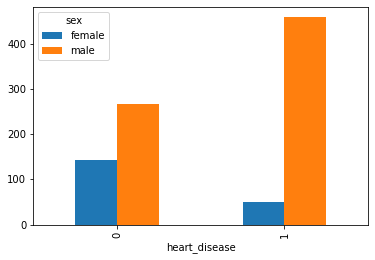



chest_pain_type

asymptomatic        496
non_anginal_pain    203
atypical_angina     173
typical_angina       46
Name: chest_pain_type, dtype: int64

heart_disease            0         1
chest_pain_type                     
asymptomatic      0.113290  0.427015
atypical_angina   0.162309  0.026144
non_anginal_pain  0.142702  0.078431
typical_angina    0.028322  0.021786


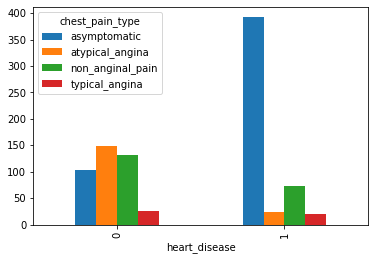



fasting_bs

0    704
1    214
Name: fasting_bs, dtype: int64

heart_disease         0         1
fasting_bs                       
0              0.398693  0.368192
1              0.047930  0.185185


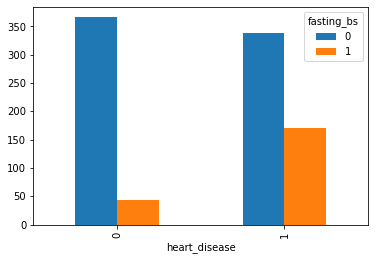



resting_ecg

normal                   552
left_vent_hypertrophy    188
abnormal_stt_wave        178
Name: resting_ecg, dtype: int64

heart_disease                 0         1
resting_ecg                              
abnormal_stt_wave      0.066449  0.127451
left_vent_hypertrophy  0.089325  0.115468
normal                 0.290850  0.310458


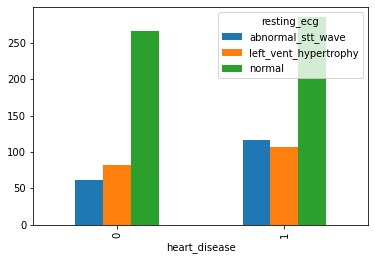



exercise_angina

no     547
yes    371
Name: exercise_angina, dtype: int64

heart_disease           0         1
exercise_angina                    
no               0.386710  0.209150
yes              0.059913  0.344227


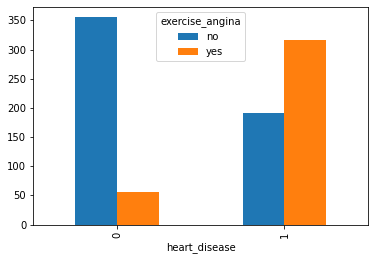



st_slope

flat    460
up      395
down     63
Name: st_slope, dtype: int64

heart_disease         0         1
st_slope                         
down           0.015251  0.053377
flat           0.086057  0.415033
up             0.345316  0.084967


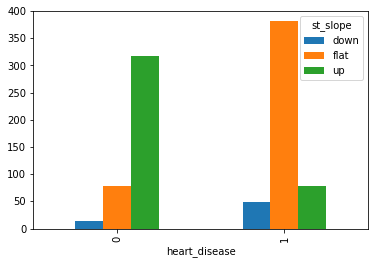

In [12]:
cat_cols = ['sex', 'chest_pain_type', 'fasting_bs', 'resting_ecg', 'exercise_angina', 'st_slope']

for col in cat_cols:
    print(col)
    print()
    print(heart[col].value_counts())
    print()
    print(pd.crosstab(heart[col], heart['heart_disease']) / len(heart))
    heart.groupby('heart_disease')[col].value_counts().unstack().plot.bar()
    plt.show()
    print('\n')

### *Summary of distributions of values for categorical columns*

**sex** - this dataset contains many more males than females, and males seem to be significantly more likely to have heart disease than females.

**chest_pain_type** - a large majority of patients with heart disease experience no chest pain (are asymptomatic)

**resting_ecg** - distributions are approximately equal between those with and without heart disease; about 60% of all patients are 'normal'

**fasting_bs** - patients are about 4x as likely to have high fasting blood sugar if they have heart disease than if they don't have heart disease

**exercise_angina** - for those without heart disease, approx. 1 out of 7 patients had angina that was exercise induced, but for those with heart disease, approx. 5 out of 8 patients had angina that was exercise induced

**st_slope** - for those without heart disease, most patients have up-sloping ST segments, but for those with heart disease, most patients have flat-sloping ST segments  

___

All of these columns have only a few unique values (most unique values for a column is 'chest_pain_type' with 4), and each unique value in each column has at least moderate representation (rarest value in the data set is a 'chest_pain_type' of 'typical_angina' at about 5% of all patients). 

Consequently, we can make dummy variables for all of these columns.

In [14]:
cat_dummies = pd.get_dummies(heart[cat_cols])
cat_dummies.columns

Index(['fasting_bs', 'sex_female', 'sex_male', 'chest_pain_type_asymptomatic',
       'chest_pain_type_atypical_angina', 'chest_pain_type_non_anginal_pain',
       'chest_pain_type_typical_angina', 'resting_ecg_abnormal_stt_wave',
       'resting_ecg_left_vent_hypertrophy', 'resting_ecg_normal',
       'exercise_angina_no', 'exercise_angina_yes', 'st_slope_down',
       'st_slope_flat', 'st_slope_up'],
      dtype='object')

In [15]:
# drop one column for each of the variables that only had two values
cat_dummies = cat_dummies.drop(['sex_female', 'exercise_angina_no'], axis=1)

# drop original categorical columns from our dataframe
heart = heart.drop(cat_cols, axis=1)

# join dummy categorical cols with remaining cols of our dataframe
heart = pd.concat([heart, cat_dummies], axis=1)

heart.head()

,age,resting_bp,cholesterol,max_hr,oldpeak,heart_disease,fasting_bs,sex_male,chest_pain_type_asymptomatic,chest_pain_type_atypical_angina,chest_pain_type_non_anginal_pain,chest_pain_type_typical_angina,resting_ecg_abnormal_stt_wave,resting_ecg_left_vent_hypertrophy,resting_ecg_normal,exercise_angina_yes,st_slope_down,st_slope_flat,st_slope_up
0,40,140,289,172,0.0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
1,49,160,180,156,1.0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
2,37,130,283,98,0.0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
3,48,138,214,108,1.5,1,0,0,1,0,0,0,0,0,1,1,0,1,0
4,54,150,195,122,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


### 5 - Numerical columns - check for any suspicious values and outliers

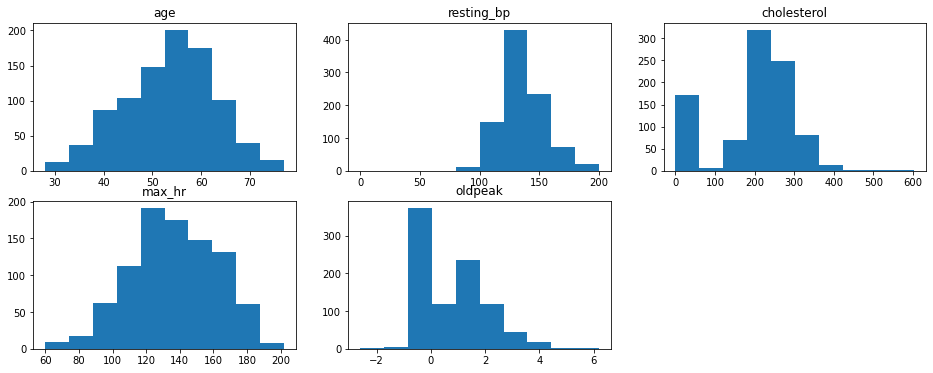

In [17]:
num_cols = ['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak']

fig = plt.figure(figsize=(16, 6))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(2, 3, i+1)
    plt.hist(heart[col])
    plt.title(col)
    
plt.show()

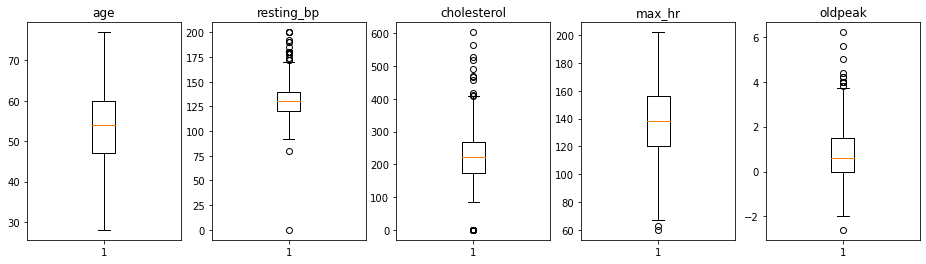

In [18]:
fig = plt.figure(figsize=(16, 4))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(1, 5, i+1)
    plt.boxplot(heart[col])
    plt.title(col)
    
plt.show()

It looks like:  
**age** seams reasonable,  
**resting_bp** has at least one zero value and *maybe* some outliers,  
**cholesterol** has tons of zero values, probably need to impute instead of remove,  
**max_hr** looks okay but might have a few outliers,  
**oldpeak** may have some outliers; I don't know enough about what **oldpeak** is measuring to judge the extreme values well.

#### age
Just verify that the age range is reasonable

In [19]:
heart['age'].min(), heart['age'].max()

(28, 77)

#### resting_bp
At least one zero value, maybe some outliers

In [14]:
heart['resting_bp'].value_counts().sort_index().head()

0     1
80    1
92    1
94    2
95    6
Name: resting_bp, dtype: int64

In [20]:
heart['resting_bp'].value_counts().sort_index().tail()

180    12
185     1
190     2
192     1
200     4
Name: resting_bp, dtype: int64

In [21]:
# drop row with a zero for resting_bp since its only one row
heart = heart[heart['resting_bp'] > 0]

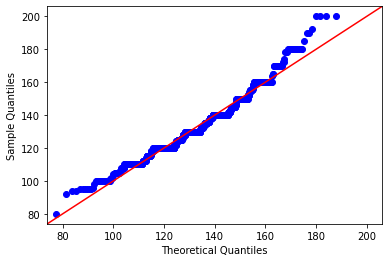

In [22]:
# check for normality of resting_bp values
sm.qqplot(heart['resting_bp'], line='45', loc=heart['resting_bp'].mean(), scale=heart['resting_bp'].std())
plt.show()

Seems close enough to Normal that we can use z-scores as a way to identify outliers

In [23]:
rbp_zscore = pd.Series(zscore(heart['resting_bp'])).abs()
rbp_zscore.value_counts().sort_index().tail()

2.916026    1
2.920572    1
3.193959    2
3.305132    1
3.749826    4
dtype: int64

Looks like we have 7 total values with a z-score of at least 3. With Normally-distributed values, we'd expect approximately 3/1000 values to be this extreme, and our dataset has 7/968 values this extreme.  This is not *too* far off from what is expected, and these "extreme" values are still technically possible, despite being unlikely. Furthermore, 4 of the values (the most extreme 4 values) are a resting_bp of 200, which is possibly the highest reading a machine would give.

I'm going to choose to leave these "outliers" in, but further fine-tuning of this dataset for learning may include removal of these rows.

#### cholesterol

Tons of zero values, too many to drop, so we should impute. Let's see how skewed these values are by computing the mean and median without the zero values.

In [24]:
# count the rows with 0 reported for cholesterol
sum(heart['cholesterol'] == 0)

171

In [25]:
# compute mean and median of the non-zero cholesterol values
non_zero = heart[heart['cholesterol'] > 0]['cholesterol']
f'mean: {non_zero.mean()},  median {non_zero.median()}'

'mean: 244.6353887399464,  median 237.0'

So, they are relatively close suggesting that this is a fairly symmetric distribution.  Let's split the difference and impute 240 for the rows that have a value of 0 for cholesterol.

<AxesSubplot:ylabel='Frequency'>

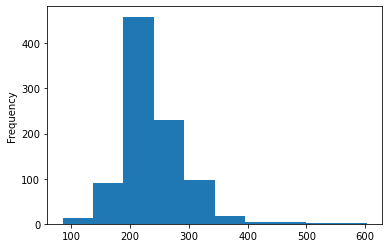

In [26]:
heart['cholesterol'] = heart['cholesterol'].replace(0, 240)
heart['cholesterol'].plot(kind='hist')

Okay, so that cleaned up the zeros.

Now, should we remove outliers?  Let's see how the target column is distributed for patients with very high cholesterol (above 400).

In [27]:
heart[heart['cholesterol'] > 400]['heart_disease'].value_counts()

1    8
0    5
Name: heart_disease, dtype: int64

<mark>Question:</mark> *I was somewhat expecting that very high cholesterol would have been a better indicator of whether or not a person has heart disease, but "very high cholesterol" is not as good of a singular predictor as I expected.  So, I think in this case that the "outliers" for cholesterol maybe should be removed; if all patients with cholesterol had heart disease, we'd definitely want to keep the outliers as they are.*

I *do* know that cholesterol *can* be as high as our highest readings (highest ever recorded was over 3000!), so I'll leave them in for now.

#### max_hr

Couple of very low values, but I don't think we know enough to drop them.

In [28]:
heart['max_hr'].value_counts().sort_index()[:15]

60    1
63    1
67    1
69    1
70    1
71    1
72    2
73    1
77    1
78    1
80    2
82    3
83    1
84    3
86    4
Name: max_hr, dtype: int64

Pretty low for max heart rate, but not completely unbelievable.

#### oldpeak

Of the numerical columns, this is the one that I understand the least.  Our boxplots suggest there may be some outliers, but I don't know enough to justify removing/altering any of these "extreme" values.

### Assemble a processed dataframe

Let's make one function that incorporates all the preprocessing steps we just did to produce a cleaned *heart* DataFrame.

Also, note that we did not min-max normalize our values - this happens as part of a Pipeline() when training and testing.

In [29]:
def get_heart_df():
    
    # read in csv
    heart = pd.read_csv('heart.csv')
    
    # fix column names
    columns = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'fasting_bs', 'resting_ecg', 'max_hr',
          'exercise_angina', 'oldpeak', 'st_slope', 'heart_disease']
    heart.columns = columns
    
    # fix column values
    heart['sex'] = heart['sex'].replace({'M': 'male', 
                                         'F': 'female'})
    heart['chest_pain_type'] = heart['chest_pain_type'].replace({'TA': 'typical_angina',
                                                                 'ATA': 'atypical_angina',
                                                                 'NAP': 'non_anginal_pain',
                                                                 'ASY': 'asymptomatic'})
    heart['resting_ecg'] = heart['resting_ecg'].replace({'Normal': 'normal',
                                                         'ST': 'abnormal_stt_wave',
                                                         'LVH': 'left_vent_hypertrophy'})
    heart['exercise_angina'] = heart['exercise_angina'].replace({'Y': 'yes',
                                                                 'N': 'no'})
    heart['st_slope'] = heart['st_slope'].replace({'Flat': 'flat',
                                                   'Up': 'up',
                                                   'Down': 'down'})
    
    # replace categorical columns with dummies
    cat_dummies = pd.get_dummies(heart[cat_cols])
    cat_dummies = cat_dummies.drop(['sex_female', 'exercise_angina_no'], axis=1)
    heart = heart.drop(cat_cols, axis=1)
    heart = pd.concat([heart, cat_dummies], axis=1)
    
    # clean up numeric columns
    heart = heart[heart['resting_bp'] > 0]
    heart['cholesterol'] = heart['cholesterol'].replace(0, 240)
    
    return heart

In [30]:
heart = get_heart_df()

<a class="anchor" id="featsel"></a>
# Feature Selection

To select features, we'll first see if there are any highly correlated variables.  

Then, we'll tune a Random Forest Classifier to help us select features.

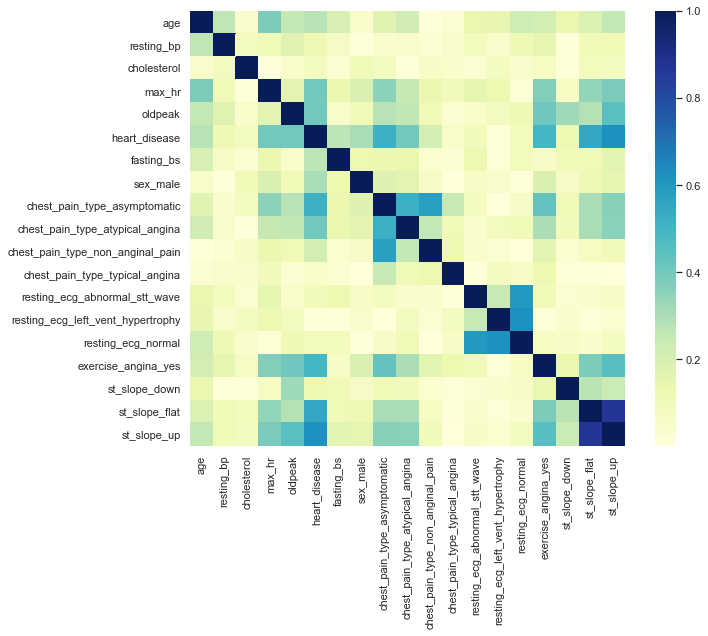

In [33]:
corrs = heart.corr().abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corrs, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.show()

Aside from *st_slope_flat* and *st_slope_up*, we don't have any very highly correlated variables, so we won't drop columns due to high correlation.

Now we'll train a Random Forest and use it to help us select columns.

The function used here is contained within *ClassificationEnsemble.py*.

This function will first perform a GridSearchCV to tune the parameters for a Random Forest.

Then, using the Random Forest with the ideal parameters, we perform RFECV to determine the ranked importance of each feature, and to get a recommended subset of features to use.

Often the RFECV will recommend more features than we may want, so we should always check the two graphs (# Features vs. AUC) and (Feature Importances) to confirm the recommendation of RFECV, or alter it.

This takes 3-5 minutes to run.

In [34]:
target = 'heart_disease'
X_train, X_test, y_train, y_test = train_test_split(heart.drop(target, axis=1), heart[target], test_size=0.2, random_state=1000)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((733, 18), (184, 18), (733,), (184,))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


RFECV selected __ 14 __ features out of 18 total features:


['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'fasting_bs', 'sex_male', 'chest_pain_type_asymptomatic', 'chest_pain_type_atypical_angina', 'chest_pain_type_non_anginal_pain', 'resting_ecg_normal', 'exercise_angina_yes', 'st_slope_flat', 'st_slope_up']





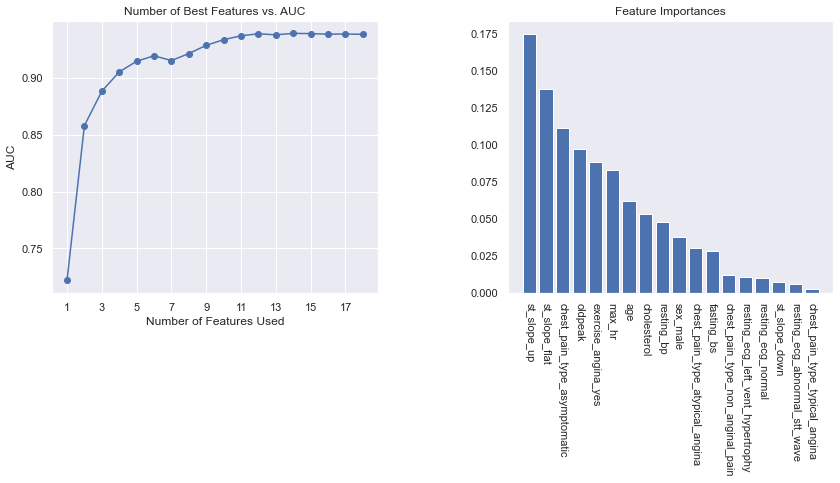

In [35]:
feat_imps, sel_cols = get_feature_importances(X_train, y_train)

As somewhat expected, RFECV selected more columns than we probably want.  I can *see* the maximum AUC at 14 features, but it is very barely higher than the AUC at 12 features, so I'll just take the first 12 features.

Note that this RFECV feature selection results will change if rerun.

Also, note that the information about the *st_slope* is pretty important. Here is a website with some good graphs describing what the *st_slope* is actually measuring: https://litfl.com/myocardial-ischaemia-ecg-library/

In [36]:
selected_feats = feat_imps[:12].index.to_list()
selected_feats

['st_slope_up',
 'st_slope_flat',
 'chest_pain_type_asymptomatic',
 'oldpeak',
 'exercise_angina_yes',
 'max_hr',
 'age',
 'cholesterol',
 'resting_bp',
 'sex_male',
 'chest_pain_type_atypical_angina',
 'fasting_bs']

<a class="anchor" id="traintest"></a>
# Train and Test

The function used here is contained within *ClassificationEnsemble.py*.

It will perform hyperparameter tuning, training, and testing on 18 different classifiers.

This takes 20-30 minutes.

Tuning LDA . . . 
Tuning QDA . . . 
Tuning AdaBoost . . . 
Tuning Bagging . . . 
Tuning Extra Trees Ensemble . . . 
Tuning Gradient Boosting . . . 
Tuning Random Forest . . . 
Tuning Ridge . . . 
Tuning SGD . . . 
Tuning BNB . . . 
Tuning GNB . . . 
Tuning KNN . . . 
Tuning MLP . . . 


C:\Users\alueh\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Tuning LSVC . . . 
Tuning NuSVC . . . 
Tuning SVC . . . 
Tuning DTC . . . 
Tuning ETC . . . 


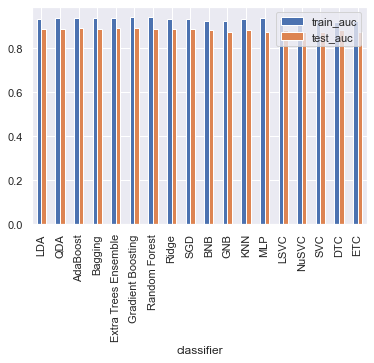

             classifier  test_auc
5     Gradient Boosting  0.893945
2              AdaBoost  0.893456
4  Extra Trees Ensemble  0.891865
1                   QDA  0.889541
3               Bagging  0.887829


In [37]:
results, resdf = train_test_all_classifiers(X_train[selected_feats], X_test[selected_feats], y_train, y_test)

In [38]:
resdf.sort_values('test_auc', ascending=False)

,classifier,train_auc,test_auc
5,Gradient Boosting,0.942821,0.893945
2,AdaBoost,0.937239,0.893456
4,Extra Trees Ensemble,0.936045,0.891865
1,QDA,0.936995,0.889541
3,Bagging,0.939142,0.887829
6,Random Forest,0.940906,0.887706
0,LDA,0.931779,0.887584
7,Ridge,0.931779,0.887584
8,SGD,0.933758,0.887339
13,LSVC,0.933234,0.885382


Here is an example of what each of the values in the *results* dictionary look like.  We'll snag the already tuned and fitted *'Classifier'* from each one.

In [39]:
results['Gradient Boosting']

{'Classifier': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('classifier',
                                         GradientBoostingClassifier(learning_rate=0.01,
                                                                    max_depth=5,
                                                                    max_features='log2',
                                                                    min_samples_leaf=0.005,
                                                                    min_samples_split=0.1,
                                                                    n_estimators=200,
                                                                    subsample=0.8))]),
              n_jobs=-1,
              param_grid={'classifier__learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                        0.005, 0.001],
                          'classifier__max_depth': [

<a class="anchor" id="stacking"></a>
# Stacking Ensembles

If it is the case that the errors in decisions by our best classifiers are generally uncorrelated, then we may benefit from creating a stacked ensemble of classifiers to improve our predictive power.  Let's take a look at the predictions from our 10 best classifiers and determine if they have low correlation or not.

In [40]:
top10 = resdf.sort_values('test_auc', ascending=False)['classifier'].to_list()[:10]
top10

['Gradient Boosting',
 'AdaBoost',
 'Extra Trees Ensemble',
 'QDA',
 'Bagging',
 'Random Forest',
 'LDA',
 'Ridge',
 'SGD',
 'LSVC']

In [44]:
classifiers = {"LDA": LinearDiscriminantAnalysis(),
               "QDA": QuadraticDiscriminantAnalysis(),
               "AdaBoost": AdaBoostClassifier(),
               "Bagging": BaggingClassifier(),
               "Extra Trees Ensemble": ExtraTreesClassifier(),
               "Gradient Boosting": GradientBoostingClassifier(),
               "Random Forest": RandomForestClassifier(),
               "Ridge": RidgeClassifier(),
               "SGD": SGDClassifier(),
               "LSVC": LinearSVC()}

decision_functions = ["Ridge", "SGD", "LSVC"]

Note that of these 10 classifiers, 7 of them have a `predict_proba()` method that returns a probability in the interval [0, 1].  The other three classifiers instead have a `decision_function()` method that returns values symmetric over 0 where positive values are predicted as 'yes' and negative values as 'no', so we'll use a different method for it here, and we'll also handle these cases separately when determining the correctness of our predictions below due to the difference in range of output.  (So, calling this DF 'predictions' is not an entirely accurate name.)

In [46]:
predictions = pd.DataFrame()

for clf in top10:
    model = results[clf]['Classifier']
    if clf in decision_functions:
        y_pred = model.decision_function(X_test[selected_feats])
    else:
        y_pred = model.predict_proba(X_test[selected_feats])[:,1]
    predictions[clf] = y_pred

    
predictions['heart_disease'] = y_test.values

predictions.head()

,Gradient Boosting,AdaBoost,Extra Trees Ensemble,QDA,Bagging,Random Forest,LDA,Ridge,SGD,LSVC,heart_disease
0,0.813093,0.825718,0.934223,0.986837,0.770564,0.862955,0.986992,0.881090,1.996494,0.955877,1
1,0.846471,0.717746,0.869594,0.974347,0.847515,0.890952,0.943912,0.574610,1.035596,0.574830,1
2,0.616688,0.725700,0.380832,0.742799,0.621024,0.611460,0.516158,0.013236,-0.002390,0.073256,0
3,0.120029,0.154082,0.046585,0.001231,0.066125,0.021352,0.020870,-0.783105,-1.588449,-0.853067,0
4,0.504035,0.498227,0.359245,0.415454,0.562747,0.517233,0.170046,-0.322549,-0.970954,-0.391864,0


In [52]:
# percent accuracy of gradient boosting on the test set
sum((predictions['Gradient Boosting'] >= .5) == predictions['heart_disease']) / len(predictions)

0.8369565217391305

Now we use the numeric results above from `predict_proba()` and `decision_function()` to determine final binary predictions, then compare the binary predictions to the actual label, being sure to handle the deicision functions separately.

In [53]:
correct = pd.DataFrame({clf: predictions[clf].round() == predictions['heart_disease'] if clf not in decision_functions
                        else (predictions[clf] > 0) == predictions['heart_disease'] for clf in top10})
correct.head()

,Gradient Boosting,AdaBoost,Extra Trees Ensemble,QDA,Bagging,Random Forest,LDA,Ridge,SGD,LSVC
0,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True
2,False,False,True,False,False,False,False,False,True,False
3,True,True,True,True,True,True,True,True,True,True
4,False,True,True,True,False,False,True,True,True,True


We want to know if these classifiers' correct/incorrect decisions are highly correlated or not in order to judge how effective a stacking ensemble might be.  The lower the correlation in correctness between classifiers, the more improvement we can expect to see from a stacked ensemble.

In [54]:
correct.corr()

,Gradient Boosting,AdaBoost,Extra Trees Ensemble,QDA,Bagging,Random Forest,LDA,Ridge,SGD,LSVC
Gradient Boosting,1.000000,0.920346,0.829084,0.823311,0.939576,0.960173,0.823311,0.823311,0.796041,0.840693
AdaBoost,0.920346,1.000000,0.790735,0.784004,0.856419,0.880519,0.784004,0.784004,0.755081,0.800866
Extra Trees Ensemble,0.829084,0.790735,1.000000,0.849323,0.766976,0.790735,0.887171,0.887171,0.866811,0.867432
QDA,0.823311,0.784004,0.849323,1.000000,0.839220,0.784004,0.961206,0.961206,0.941199,0.980540
Bagging,0.939576,0.856419,0.766976,0.839220,1.000000,0.939576,0.839220,0.839220,0.807805,0.856419
Random Forest,0.960173,0.880519,0.790735,0.784004,0.939576,1.000000,0.784004,0.784004,0.755081,0.800866
LDA,0.823311,0.784004,0.887171,0.961206,0.839220,0.784004,1.000000,1.000000,0.941199,0.980540
Ridge,0.823311,0.784004,0.887171,0.961206,0.839220,0.784004,1.000000,1.000000,0.941199,0.980540
SGD,0.796041,0.755081,0.866811,0.941199,0.807805,0.755081,0.941199,0.941199,1.000000,0.959879
LSVC,0.840693,0.800866,0.867432,0.980540,0.856419,0.800866,0.980540,0.980540,0.959879,1.000000


In [55]:
correct.corr().min().min()

0.7550809976449248

It appears that most of our best classifiers are relatively highly correlated in their predictions, and so we shouldn't expect a major improvement from building a stacked ensemble.  Let's do it anyway to validate our expectations.

Here we fit a simple Logistic Regression classifier on only the *predictions* DataFrame information, then use the fitted model to predict on itself (so notice that while this is associated with our *test* data, we are training our meta-model on the results of predicting on our test set.

In [56]:
meta = LogisticRegression()
meta.fit(predictions.drop(target, axis=1), predictions[target])
meta_preds = meta.predict_proba(predictions.drop(target, axis=1))[:,1]
auc = metrics.roc_auc_score(y_test, meta_preds)
auc

0.8923547400611621

We can see that this AUC score of our meta-model was almost identical to the best test AUCs from individual best models.  Note that this is not an apples-to-apples comparison - our original models were trained on the training data and tested on the testing data to determine a test AUC.  The meta-model, on the other hand, was trained on the predictive results from each of the models on the *test* data, and then made prediction on that same test data to determine an AUC. So, the meta-model AUC is more like a training AUC than a test AUC since we made predictions on the same data we fit with, even though that is technically labeled as the test data.

In any event, we should see *higher* than appropriate AUCs for training AUCs, and instead saw our meta-model have a training AUC tied with the best individual model test AUC, and so we can conclude that there is not likely any major benefit to be obtained from stacking in this case.